## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Fri May 20 12:18:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:DA:00.0 Off |                  N/A |
| 28%   36C    P0    55W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [6]:
def train(pred, opt, train_dataset, train_loader, val_dataset, val_loader):
    device = torch.device('cuda:0')
    pred = pred.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(50):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            #print(preds)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()

        train_loss = np.log(total_loss / len(train_dataset))
        val_loss = np.log(val_loss / len(val_dataset))

        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 17.931186251073658 val_loss: 13.13607456634607
epoch 1 train_loss: 12.387891349263576 val_loss: 12.122066270347547
epoch 2 train_loss: 11.935927420505374 val_loss: 11.870722450974487
epoch 3 train_loss: 11.829484379116002 val_loss: 11.839789026258744
epoch 4 train_loss: 11.802931306432207 val_loss: 11.803971392665122
epoch 5 train_loss: 11.793780773533125 val_loss: 11.771941707818089
epoch 6 train_loss: 11.784589074337163 val_loss: 11.780953418458111
epoch 7 train_loss: 11.774292261555432 val_loss: 11.819689875375772
epoch 8 train_loss: 11.76293433052179 val_loss: 11.854898284103536
epoch 9 train_loss: 11.753749857385063 val_loss: 11.870129497755364
epoch 10 train_loss: 11.746082024772768 val_loss: 11.867416551372786
epoch 11 train_loss: 11.736962336199632 val_loss: 11.854649340254966
epoch 12 train_loss: 11.723832969811513 val_loss: 11.841582424206377
epoch 13 train_loss: 11.707978709735238 val_loss: 11.834158360550083
epoch 14 train_loss: 11.688439438

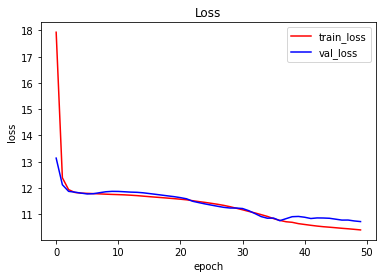

city: miami
epoch 0 train_loss: 19.440524799423525 val_loss: 13.846903520084243
epoch 1 train_loss: 12.820559246262828 val_loss: 12.038136501970428
epoch 2 train_loss: 11.843284120322066 val_loss: 11.688908072730161
epoch 3 train_loss: 11.653382182481774 val_loss: 11.66920756242049
epoch 4 train_loss: 11.593245422890293 val_loss: 11.536040669403505
epoch 5 train_loss: 11.568425279616793 val_loss: 11.564898383218262
epoch 6 train_loss: 11.555269100699872 val_loss: 11.571426704195286
epoch 7 train_loss: 11.552143904835775 val_loss: 11.59356952573248
epoch 8 train_loss: 11.575399597308618 val_loss: 11.577925122722045
epoch 9 train_loss: 11.566765613917203 val_loss: 11.481682850755885
epoch 10 train_loss: 11.570106791732526 val_loss: 11.476452273935609
epoch 11 train_loss: 11.560723276368348 val_loss: 11.47616447575183
epoch 12 train_loss: 11.56226157117924 val_loss: 11.471652428629264
epoch 13 train_loss: 11.565136078529832 val_loss: 11.460211267999082
epoch 14 train_loss: 11.559908482463

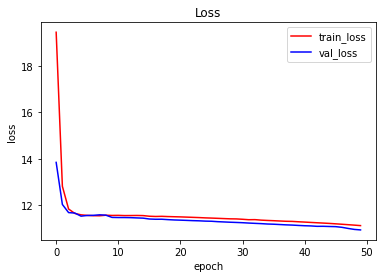

city: pittsburgh
epoch 0 train_loss: 19.203995924695167 val_loss: 17.648795973809776
epoch 1 train_loss: 16.957378174302516 val_loss: 12.38869277192097
epoch 2 train_loss: 11.821142832009452 val_loss: 11.567083606810106
epoch 3 train_loss: 11.52894430001208 val_loss: 11.49101723080922
epoch 4 train_loss: 11.498995668919852 val_loss: 11.493218202934322
epoch 5 train_loss: 11.493496374389094 val_loss: 11.5675929055323
epoch 6 train_loss: 11.495185110232597 val_loss: 11.61743057631566
epoch 7 train_loss: 11.496841282744306 val_loss: 11.511543567949568
epoch 8 train_loss: 11.491767461041658 val_loss: 11.450830467700126
epoch 9 train_loss: 11.490162585029006 val_loss: 11.468802085709882
epoch 10 train_loss: 11.4891537197388 val_loss: 11.565962486184024
epoch 11 train_loss: 11.489655919780542 val_loss: 11.622344987467883
epoch 12 train_loss: 11.491629978842115 val_loss: 11.596895262624834
epoch 13 train_loss: 11.49966333109116 val_loss: 11.546996997439857
epoch 14 train_loss: 11.510461543874

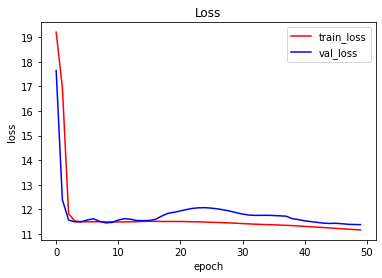

city: dearborn
epoch 0 train_loss: 21.3872475896552 val_loss: 18.318517187207807
epoch 1 train_loss: 17.016945017346444 val_loss: 15.060971969127513
epoch 2 train_loss: 14.604062785460778 val_loss: 13.14875584177196
epoch 3 train_loss: 12.790511080079057 val_loss: 12.464601605014025
epoch 4 train_loss: 12.438988368997137 val_loss: 12.343462022157508
epoch 5 train_loss: 12.364987998114513 val_loss: 12.28439078090089
epoch 6 train_loss: 12.323418478931268 val_loss: 12.281332426718322
epoch 7 train_loss: 12.301061461280598 val_loss: 12.287534882109092
epoch 8 train_loss: 12.28211016354458 val_loss: 12.305388258616752
epoch 9 train_loss: 12.26944286181433 val_loss: 12.371480771370697
epoch 10 train_loss: 12.262812666732602 val_loss: 12.433897292992631
epoch 11 train_loss: 12.258346311120924 val_loss: 12.478551737904173
epoch 12 train_loss: 12.253836538549667 val_loss: 12.507626439641445
epoch 13 train_loss: 12.249655348583325 val_loss: 12.517383629487066
epoch 14 train_loss: 12.24558896992

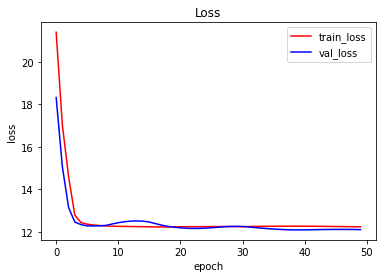

city: washington-dc
epoch 0 train_loss: 20.010243207158773 val_loss: 17.24123996780252
epoch 1 train_loss: 17.064630782133897 val_loss: 16.151461372047766
epoch 2 train_loss: 14.766062030376458 val_loss: 13.345780001034804
epoch 3 train_loss: 12.814835197089673 val_loss: 12.207794575661449
epoch 4 train_loss: 12.09684318266239 val_loss: 11.789631535610017
epoch 5 train_loss: 11.858487015204485 val_loss: 11.681943915189857
epoch 6 train_loss: 11.779106912530109 val_loss: 11.639527506317181
epoch 7 train_loss: 11.74130513738041 val_loss: 11.61846898385934
epoch 8 train_loss: 11.71886375473486 val_loss: 11.609994550291066
epoch 9 train_loss: 11.703808026535597 val_loss: 11.61162753501109
epoch 10 train_loss: 11.691931493861105 val_loss: 11.617114630039882
epoch 11 train_loss: 11.682503009596877 val_loss: 11.614951628050473
epoch 12 train_loss: 11.674492237831341 val_loss: 11.609802378489661
epoch 13 train_loss: 11.669162064392738 val_loss: 11.610140123287872
epoch 14 train_loss: 11.665982

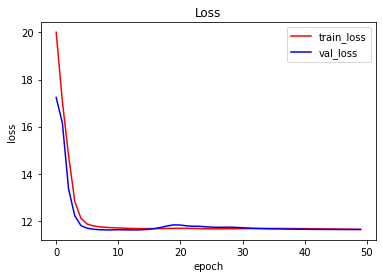

city: palo-alto
epoch 0 train_loss: 19.17264293547553 val_loss: 18.10648812022793
epoch 1 train_loss: 17.460590361398268 val_loss: 16.511634635178346
epoch 2 train_loss: 15.784146324247187 val_loss: 14.43786548197443
epoch 3 train_loss: 13.455507283185081 val_loss: 12.689043110360775
epoch 4 train_loss: 12.553109091215786 val_loss: 12.429619897098933
epoch 5 train_loss: 12.388839728694558 val_loss: 12.323896156499751
epoch 6 train_loss: 12.311383725068833 val_loss: 12.262044670656152
epoch 7 train_loss: 12.264518526016094 val_loss: 12.234230370533998
epoch 8 train_loss: 12.23526153194622 val_loss: 12.223735171611144
epoch 9 train_loss: 12.212465723042229 val_loss: 12.208153099122713
epoch 10 train_loss: 12.191782559214863 val_loss: 12.181224861947795
epoch 11 train_loss: 12.176191052091603 val_loss: 12.155684501016408
epoch 12 train_loss: 12.165086514309266 val_loss: 12.137366955651249
epoch 13 train_loss: 12.15635608683928 val_loss: 12.126108999803874
epoch 14 train_loss: 12.148220398

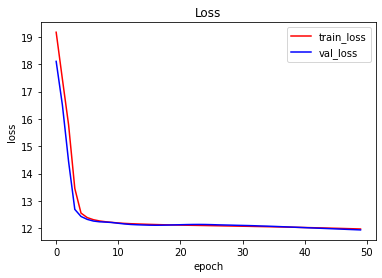

CPU times: user 3min 49s, sys: 6.22 s, total: 3min 55s
Wall time: 3min 51s


In [7]:
%%time
import pickle
#train city models
for city in cities:
    print('city: ' + city)
    batch_sz = 128  # batch size
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    pred = Pred()
    opt = optim.Adam(pred.parameters(), lr=2e-4)
    train(pred, opt, train_dataset, train_loader, val_dataset, val_loader)
    pickle.dump(pred, open('ta_model_baseline_' + city, 'wb'))

In [8]:
import pandas as pd
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    load_pred = pickle.load(open('ta_model_baseline_' + city, 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [9]:
all_predictions

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-35.646385,-564.556335,-35.843044,-565.246277,-36.392094,-565.548767,-34.129986,-564.704346,-34.048580,...,-32.314117,-566.145874,-33.673073,-567.533447,-33.714165,-565.352356,-33.651443,-566.370361,-34.014732,-566.678711
1,1_austin,-347.586975,-12.510969,-347.105774,-12.788177,-347.577118,-15.373632,-348.009735,-11.875762,-347.131836,...,-345.293365,-12.848145,-345.744110,-12.080602,-343.048859,-14.423719,-344.445312,-12.746428,-342.839905,-13.503588
2,2_austin,52.292965,-249.153839,52.346107,-248.666458,51.400726,-248.998444,51.477436,-248.307388,51.700768,...,52.811893,-249.384750,52.786842,-248.477570,52.367310,-249.871719,52.801155,-249.349991,51.843014,-249.373322
3,3_austin,-106.951096,1792.769531,-105.010040,1791.562744,-105.943962,1792.321655,-103.789482,1792.456421,-106.567719,...,-95.315399,1787.108521,-93.213821,1793.432617,-93.899826,1789.382690,-94.618195,1791.231079,-92.263023,1787.868164
4,4_austin,1226.906982,-652.272461,1227.097778,-646.652100,1222.434082,-650.971008,1229.844482,-652.488037,1225.564941,...,1233.320068,-656.979370,1236.056763,-652.227905,1233.517456,-659.019165,1234.712402,-654.473816,1232.538574,-654.412354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1385.287354,-460.426331,-1380.776733,-461.190063,-1380.695923,-462.279724,-1384.988525,-461.701294,-1383.289062,...,-1368.622314,-469.239166,-1379.109741,-455.256195,-1376.202148,-466.640076,-1363.880127,-459.745422,-1375.023804,-463.403412
29839,1682_palo-alto,128.678879,-37.629971,129.935867,-38.154228,129.317276,-37.539169,128.578156,-37.556053,128.766846,...,129.638779,-37.775150,130.258560,-35.779831,128.942993,-36.716248,129.099075,-36.260246,129.076126,-37.493576
29840,1683_palo-alto,-1450.032104,2170.785645,-1451.728149,2174.138916,-1447.593018,2174.031006,-1450.204590,2171.910400,-1451.995605,...,-1444.619507,2177.399170,-1445.511841,2177.559326,-1445.638062,2177.074707,-1447.102295,2174.739258,-1446.107056,2176.354004
29841,1684_palo-alto,1048.192261,1382.367310,1046.368652,1398.683228,1048.355591,1384.483276,1051.488892,1388.268311,1055.826904,...,1044.473633,1392.719849,1047.747070,1390.432373,1051.738403,1399.739624,1042.208008,1396.866089,1051.914917,1390.431885


In [10]:
all_predictions.to_csv('out.csv', index=False)

In [11]:
pd.read_csv('out.csv')

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-35.646385,-564.556340,-35.843044,-565.246300,-36.392094,-565.548770,-34.129986,-564.704350,-34.048580,...,-32.314117,-566.145900,-33.673073,-567.533450,-33.714165,-565.352360,-33.651443,-566.370360,-34.014732,-566.678700
1,1_austin,-347.586980,-12.510969,-347.105770,-12.788177,-347.577120,-15.373632,-348.009740,-11.875762,-347.131840,...,-345.293370,-12.848145,-345.744100,-12.080602,-343.048860,-14.423719,-344.445300,-12.746428,-342.839900,-13.503588
2,2_austin,52.292965,-249.153840,52.346107,-248.666460,51.400726,-248.998440,51.477436,-248.307390,51.700768,...,52.811893,-249.384750,52.786842,-248.477570,52.367310,-249.871720,52.801155,-249.349990,51.843014,-249.373320
3,3_austin,-106.951096,1792.769500,-105.010040,1791.562700,-105.943960,1792.321700,-103.789480,1792.456400,-106.567720,...,-95.315400,1787.108500,-93.213820,1793.432600,-93.899826,1789.382700,-94.618195,1791.231100,-92.263020,1787.868200
4,4_austin,1226.907000,-652.272460,1227.097800,-646.652100,1222.434100,-650.971000,1229.844500,-652.488040,1225.565000,...,1233.320100,-656.979400,1236.056800,-652.227900,1233.517500,-659.019170,1234.712400,-654.473800,1232.538600,-654.412350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1385.287400,-460.426330,-1380.776700,-461.190060,-1380.695900,-462.279720,-1384.988500,-461.701300,-1383.289100,...,-1368.622300,-469.239170,-1379.109700,-455.256200,-1376.202100,-466.640080,-1363.880100,-459.745420,-1375.023800,-463.403400
29839,1682_palo-alto,128.678880,-37.629970,129.935870,-38.154230,129.317280,-37.539170,128.578160,-37.556053,128.766850,...,129.638780,-37.775150,130.258560,-35.779830,128.943000,-36.716248,129.099080,-36.260246,129.076130,-37.493576
29840,1683_palo-alto,-1450.032100,2170.785600,-1451.728100,2174.139000,-1447.593000,2174.031000,-1450.204600,2171.910400,-1451.995600,...,-1444.619500,2177.399200,-1445.511800,2177.559300,-1445.638100,2177.074700,-1447.102300,2174.739300,-1446.107000,2176.354000
29841,1684_palo-alto,1048.192300,1382.367300,1046.368700,1398.683200,1048.355600,1384.483300,1051.488900,1388.268300,1055.826900,...,1044.473600,1392.719800,1047.747100,1390.432400,1051.738400,1399.739600,1042.208000,1396.866100,1051.914900,1390.431900
